# WikiLetters miniproject

Inspired by [this tweet](https://twitter.com/anniierau/status/1677769248159014912), I took a look at the traffic patterns towards English Wikipedia articles about letters of the alphabet.

Some strange, as yet unexplained, patterns observed... I welcome any suggested explanations!

Data comes from the [Wikipedia clickstream dataset](https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream). This is used to understand where page views come from. Some more detail on the external sources and higher granularity would be nice but unfortunately that is not available. Strictly speaking not 100% of an article's page views are included here due to an edge weight threshold (see details in link), but it's close enough.

![ ](figures/tweet.png "aztweet")

#### Quick primer on network data

The clickstream data for each month forms a network. Each entry represents an 'edge' in the network, detailing where traffic comes from (the source), where it goes to (the target), and how many times it has been visited (the weight / "n"). The source and target are both 'nodes' in the network. The source is the page that a user was on before they navigasted to the target page (e.g. through a link on the source page). The weight is the number of times in a month that all users traversed from a specific source page to a specifc target page.

This network is _directed_ (meaning each edge has a direction, from source to target), and _weighted_ (meaning each edge has a weight, the number of times that edge was traversed).

Most of the entries in the clickstream data represent the number of times in one month that users have clicked a link on some source article towards some target article. However there is also data on traffic from sources external to Wikipedia which we make use of. See the link above for more details.

#### Downloading & reading clickstream data
First run of this can take a little while, but data is saved for future speedier use.

In [1]:
# import functions from wikiletters.py
from wikiletters import *

fp = '' # enter path to folder with clickstream data here
savepath = 'data' # enter path to folder to save output to here

startm = '2021-07-01'
endm = '2023-06-01'
months = pd.date_range(startm, endm, freq='MS')
split = months[len(months)//2] # get point to split data in half for comparison

# check if data has already been downloaded and processed
if (os.path.exists('%s/az_clickstream_%s_%s.csv' %(savepath, startm , endm))&
    os.path.exists('%s/agg_clickstream_%s_%s.csv' %(savepath, startm , endm))):
    dft = pd.read_csv('%s/az_clickstream_%s_%s.csv' %(savepath, startm , endm),
                      index_col=0, parse_dates=['month'])
    dfg = pd.read_csv('%s/agg_clickstream_%s_%s.csv' %(savepath, startm , endm),
                      index_col=0, parse_dates=[0])
else: # if not, download, process, and save data
    download_clickstream(startm, endm, fp)
    dft, dfg = get_abc_clickstream(startm, endm, fp)
    dft.to_csv('%s/az_clickstream_%s_%s.csv' %(savepath, startm , endm))
    dfg.to_csv('%s/agg_clickstream_%s_%s.csv' %(savepath, startm , endm))

display(dft.head()) # all edges to letters of the alphabet
display(dfg.head()) # aggregated data across all articles for different sources

,source,target,type,n,type2,month
386,other-search,A,external,83284,Search Engines,2021-07-01
404,other-empty,A,external,64369,No Record,2021-07-01
444,other-internal,A,external,6314,Wikimedia,2021-07-01
388,other-external,A,external,1278,Rest of the Web,2021-07-01
442,Main_Page,A,other,1117,Wikipedia Other,2021-07-01


,Search Engines,Rest of the Web,No Record,Unknown,Wikimedia,Wikipedia Link,Wikipedia Other
2021-07-01,3079018876,66824340,1436272303,149779,125543119,2255489317,65494170
2021-08-01,3053078620,69360537,1421374549,130745,126638318,2249276871,63354813
2021-09-01,2954325919,66275924,1317654573,193580,119765805,2045986483,57496100
2021-10-01,3018637196,68711456,1316391400,349130,121836833,2080902700,58488064
2021-11-01,2856159667,67904845,1254032762,336090,115326252,1921539436,52515893


#### Aggregating data in various ways
The dataframes created below summarise different aspects of the data:
- `agg_df`: total pageviews from all sources to each letter over full period
- `agg_m_df`: total pageviews from each source to each letter (Wikipedia source articles disaggregated) over full period
- `agg_mt_df`: total pageviews from all sources to each letter per month
- `agg_t_df`: total pageviews from each source to each letter (Wikipedia source articles aggregated) over full period
- `agg_tm_df`: total pageviews from each source to each letter (Wikipedia source articles aggregated) per month

In [2]:
agg_df = dft.groupby('target')['n'].sum().sort_values(ascending=False).reset_index()
agg_m_df = dft.groupby(['target', 'source', 'type'])['n'].sum().sort_values(ascending=False).reset_index()
agg_mt_df = dft.groupby(['target', 'month'])['n'].sum().sort_values(ascending=False).reset_index()
agg_t_df = dft.groupby(['target', 'type2'])['n'].sum().sort_values(ascending=False).reset_index()
agg_tm_df = dft.groupby(['target', 'type2', 'month'])['n'].sum().sort_values(ascending=False).reset_index()
display(agg_df.head()) # total pageviews from all sources
display(agg_m_df.head()) # total pageviews from each source (articles disaggregated)
display(agg_mt_df.head()) # total pageviews from each month
display(agg_t_df.head()) # total pageviews from each source (articles aggregated)
display(agg_tm_df.head()) # total pageviews from each source each month (articles aggregated)

,target,n
0,A,5063079
1,G,3604129
2,L,3259600
3,H,2858547
4,Y,2220332


,target,source,type,n
0,A,other-empty,external,2923877
1,G,other-empty,external,2255170
2,L,other-empty,external,1775921
3,A,other-search,external,1719295
4,H,other-empty,external,1626018


,target,month,n
0,G,2023-05-01,543458
1,G,2023-06-01,516054
2,A,2023-06-01,417423
3,A,2023-05-01,411836
4,A,2023-03-01,384302


,target,type2,n
0,A,No Record,2923877
1,G,No Record,2255170
2,L,No Record,1775921
3,A,Search Engines,1719295
4,H,No Record,1626018


,target,type2,month,n
0,G,Search Engines,2023-05-01,359876
1,G,Search Engines,2023-06-01,348979
2,A,No Record,2023-03-01,245137
3,A,No Record,2023-02-01,241168
4,A,Search Engines,2023-06-01,203479


#### Investigating page views over time
Total page views towards the letter articles start increasing dramatically around June 2022, tripling in volume in 1 year!

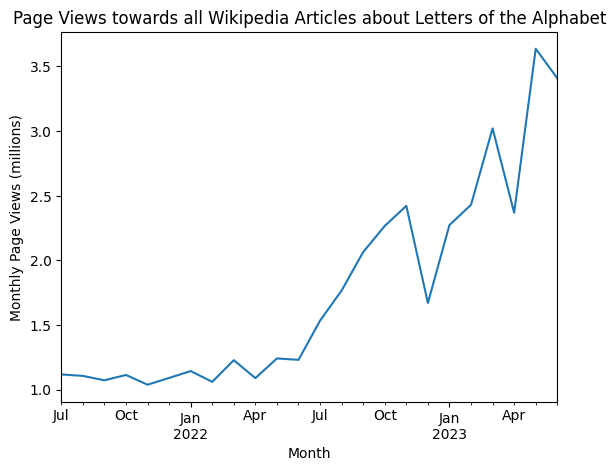

In [3]:
tpd = dft.groupby('month')['n'].sum()/1000000 # group & convert to millions

tpd.plot()
plt.title('Page Views towards all Wikipedia Articles about Letters of the Alphabet')
plt.xlabel('Month')
plt.ylabel('Monthly Page Views (millions)')
plt.savefig('figures/total_pageviews.png', dpi=300, bbox_inches='tight')
plt.show()

#### Traffic sources

Sources with no recorded origin are primarily responsible for this increase in traffic, initially at least, with Search Engines also contributing significantly from Jan 2023.

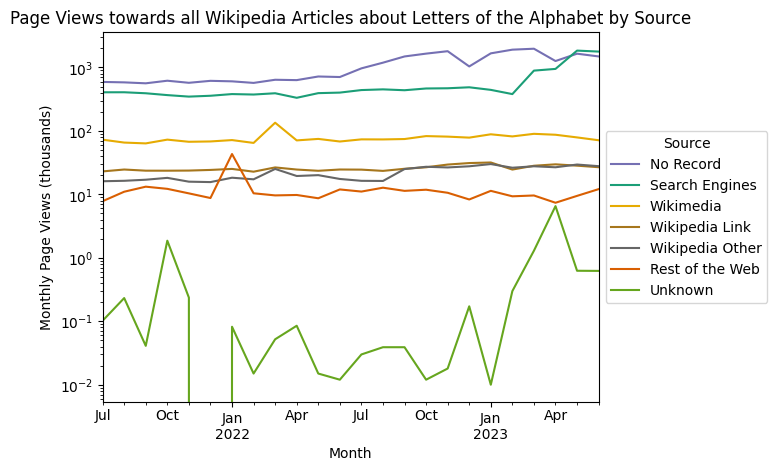

In [4]:
# group, reshape, convert to thousands, sort cols by total
ttpd = dft.groupby(['type2', 'month'])['n'].sum().unstack().T/1000
ttpd = ttpd[ttpd.sum().sort_values(ascending=False).index].fillna(0)

# specify colours for each source (used for consistency between plots)
cmap = cm.Dark2(np.linspace(0, 1, 7))
sources = ['Search Engines', 'Rest of the Web', 'No Record', 'Unknown',
           'Wikimedia', 'Wikipedia Link', 'Wikipedia Other']
source_colours = {x: cmap[n] for n, x in enumerate(sources)}

# plot
for source in ttpd.columns:
    ttpd[source].plot(color=source_colours[source])
plt.title('Page Views towards all Wikipedia Articles about Letters of the Alphabet by Source')
plt.xlabel('Month')
plt.ylabel('Monthly Page Views (thousands)')
plt.yscale('log')
plt.legend(title='Source', bbox_to_anchor=(1, 0.75))
plt.savefig('figures/pageview_sources.png', dpi=300, bbox_inches='tight')
plt.show()

#### Page view targets

Different letters have different baseline page views. Lets look at the increase in page views above this baseline (calculated from first year monthly average).

G, A, S, L, and H have the largest increases in page views, some letters have no notable increase at all.

There are some strange dips across all letters in December 2022 and April 2023. I'm not sure what could be responsible for this?

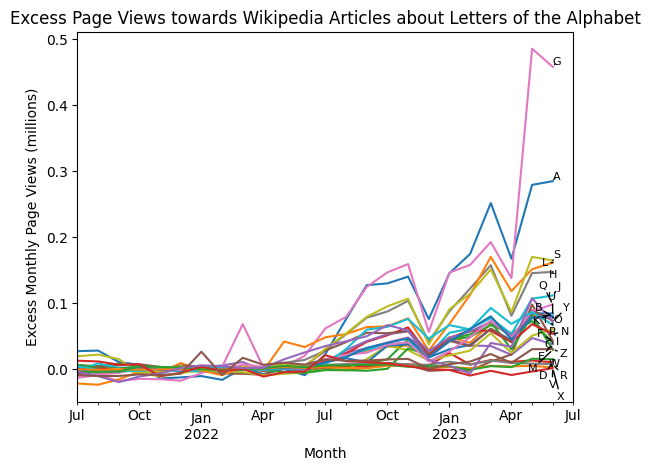

In [5]:
# get average per letter over first period
mean_y1 = agg_mt_df[agg_mt_df['month']<split].groupby('target')['n'].mean()
# get excess views per letter per month, convert to millions
xpd = (dft.groupby(['target', 'month'])['n'].sum() - mean_y1
       ).unstack().T/1000000

# plot
xpd.plot(legend=False)
texts = []
for k, v in xpd.iloc[-1].sort_values().to_dict().items(): # add letter labels
    texts.append(plt.text(xpd.index[-1], v, k, fontsize=8))
plt.title('Excess Page Views towards Wikipedia Articles about Letters of the Alphabet')
plt.xlabel('Month')
plt.ylabel('Excess Monthly Page Views (millions)')
plt.xlim(xpd.index[0], pd.to_datetime(endm) + pd.DateOffset(months=1))
# jitter the letter labels
adjust_text(texts, arrowprops=dict(arrowstyle="-"), avoid_self=False)
plt.savefig('figures/az_excess_views.png', dpi=300, bbox_inches='tight')
plt.show()

Considering pageviews relative to their first year average is a similar story. Page views for the letter G increased 800% over the course of the last year, most letters increased somewhat, but some not at all.

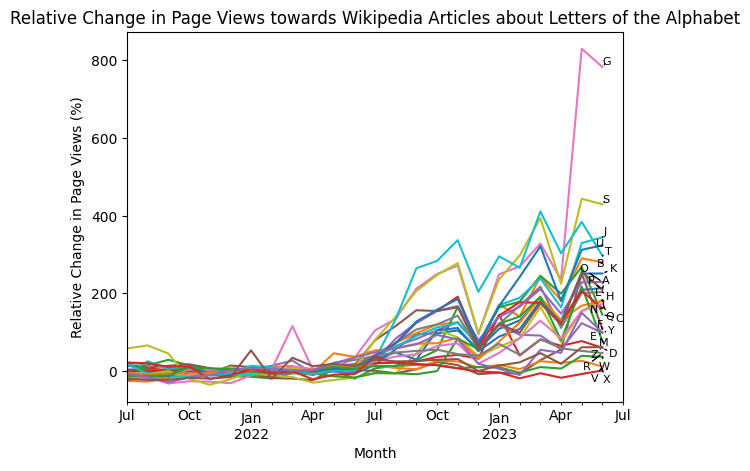

In [6]:
# get scaled views per letter per month, compared to first period average
rpd = (dft.groupby(['target', 'month'])['n'].sum() / mean_y1).unstack().T*100 - 100

# plot
rpd.plot(legend=False)
texts=[]
for k, v in rpd.iloc[-1].sort_values().to_dict().items(): # add letter labels
    texts.append(plt.text(rpd.index[-1], v, k, fontsize=8))
plt.title('Relative Change in Page Views towards Wikipedia Articles about Letters of the Alphabet')
plt.xlabel('Month')
plt.ylabel('Relative Change in Page Views (%)')
plt.xlim(rpd.index[0], pd.to_datetime(endm) + pd.DateOffset(months=1))
# jitter the letter labels
adjust_text(texts, arrowprops=dict(arrowstyle="-"), avoid_self=False)
plt.savefig('figures/az_relative_views.png', dpi=300, bbox_inches='tight')
plt.show()

#### Visualising the traffic by source and target

Need to create a clean edgelist for where clicks come from, which article they go to, and how many clicks there are. Do this for year 1 of data and year 2 of data.

In [7]:
# create edgelists for navigation networks
el = agg_tm_df.rename(columns={'type2': 'source', 'n':'weight'})
el_y1 = el[el['month']<split].groupby(['source', 'target'])['weight'].sum().reset_index()
el_y2 = el[el['month']>=split].groupby(['source', 'target'])['weight'].sum().reset_index()
display(el_y1.head())
display(el_y2.head())

,source,target,weight
0,No Record,A,726999
1,No Record,B,183019
2,No Record,C,159758
3,No Record,D,101193
4,No Record,E,185806


,source,target,weight
0,No Record,A,2196878
1,No Record,B,556402
2,No Record,C,442075
3,No Record,D,163337
4,No Record,E,479767


Plotting this data, we see the large increase in page views in year 2 vs year 1, how this is primarily driven by 'No Record' and 'Search Engines', plus more detail on how this varies by letter.

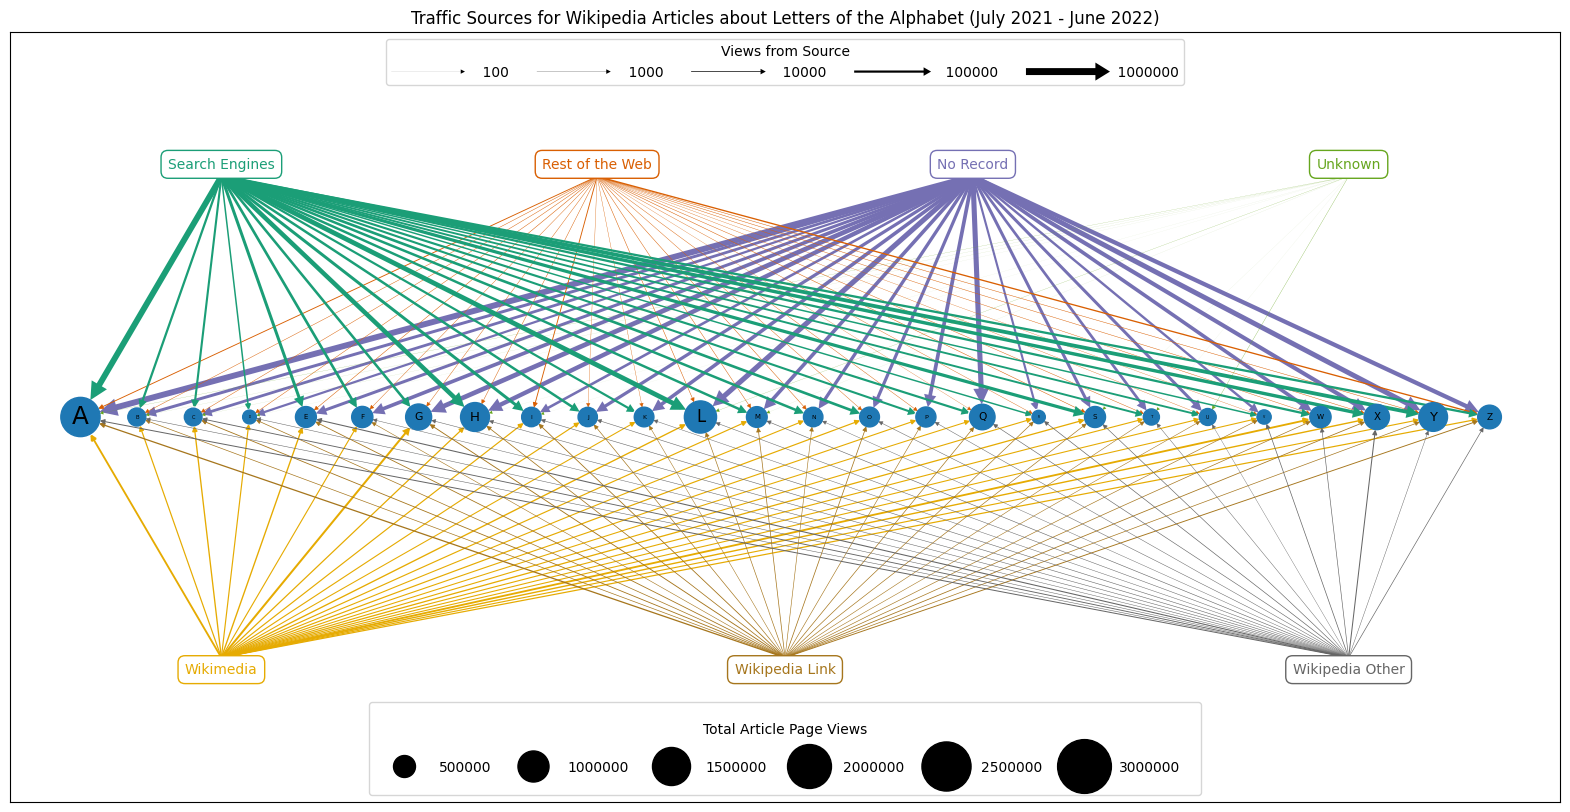

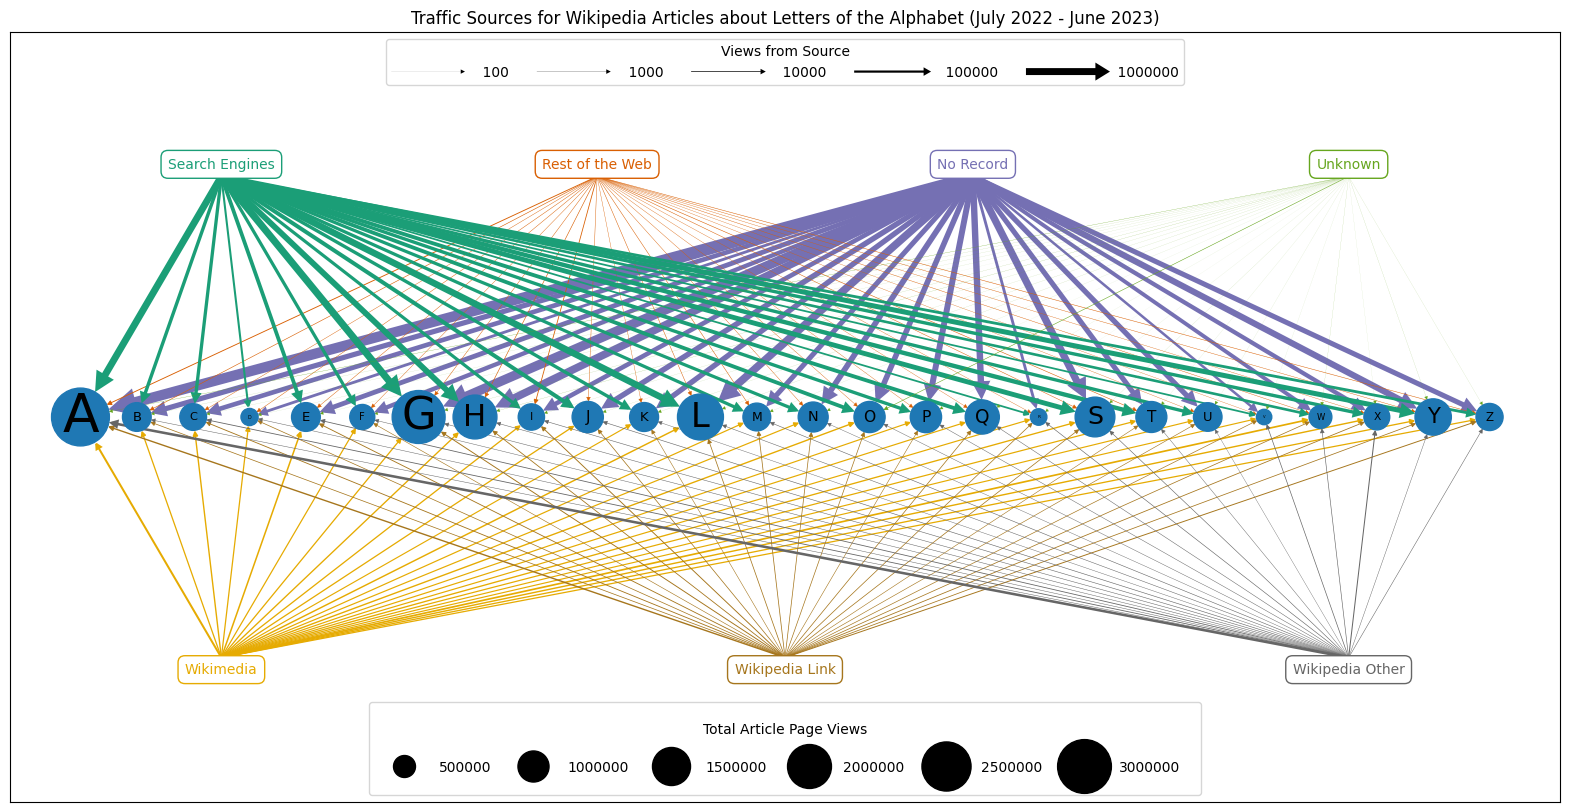

In [8]:
# plot clickstream data for each letter
plot_az_fig(el_y1, ' (July 2021 - June 2022)')
plot_az_fig(el_y2, ' (July 2022 - June 2023)')

#### More edge details

1. Comparing traffic by source in year 1 vs year 2.
2. Finding the edges with the largest increase in traffic.
3. Within Wikipedia, find the edges with the highest traffic (links in articles clicked the most.)

In [9]:
# 1. absolute and relative change in views by source, y2 vs y1

display(el_y2.groupby('source')['weight'].sum() - el_y1.groupby('source')['weight'].sum())
display(el_y2.groupby('source')['weight'].sum() / el_y1.groupby('source')['weight'].sum())

source
No Record          10672221
Rest of the Web      -31901
Search Engines      4485797
Unknown                6951
Wikimedia             66417
Wikipedia Link        39974
Wikipedia Other       90261
Name: weight, dtype: int64

source
No Record          2.439656
Rest of the Web    0.796787
Search Engines     1.985913
Unknown            3.543359
Wikimedia          1.074234
Wikipedia Link     1.137810
Wikipedia Other    1.416229
Name: weight, dtype: float64

In [10]:
# 2. show edges with the largest increase in views y2 vs y1

display((el_y2.groupby(['source', 'target'])['weight'].sum().sub(
    el_y1.groupby(['source', 'target'])['weight'].sum(), fill_value=0).sort_values(ascending=False)).head())

source          target
No Record       A         1469879.0
                G         1346226.0
Search Engines  G          903355.0
No Record       S          894121.0
                H          845744.0
Name: weight, dtype: float64

In [11]:
# 3. show top wikipedia article sources in each periods

dfl = dft[dft['type'] == 'link']
display(dfl.groupby(['source', 'target'])['n'].sum().sort_values(ascending=False).head().reset_index())
display(dfl[dfl['month']<split].groupby(['source', 'target'])['n'].sum().sort_values(ascending=False).head().reset_index())
display(dfl[dfl['month']>=split].groupby(['source', 'target'])['n'].sum().sort_values(ascending=False).head().reset_index())

,source,target,n
0,Freemasonry,G,15385
1,English_alphabet,A,14308
2,Roman_numerals,I,9236
3,C_(programming_language),C,8414
4,Roman_numerals,M,7621


,source,target,n
0,English_alphabet,A,7421
1,Freemasonry,G,7044
2,Roman_numerals,I,4717
3,C_(programming_language),C,4347
4,Shibboleth,H,4038


,source,target,n
0,Freemasonry,G,8341
1,English_alphabet,A,6887
2,English_alphabet,I,5069
3,English_alphabet,N,4610
4,Roman_numerals,I,4519


#### Internal Wikipedia link plot

A slightly simpler / uglier / less informative version of the above plot, restricted to links between Wikipedia articles.

The alphabet page features strongly, as well as Roman numerals, and the Freemasonry -> G link. Probably a conspiracy.

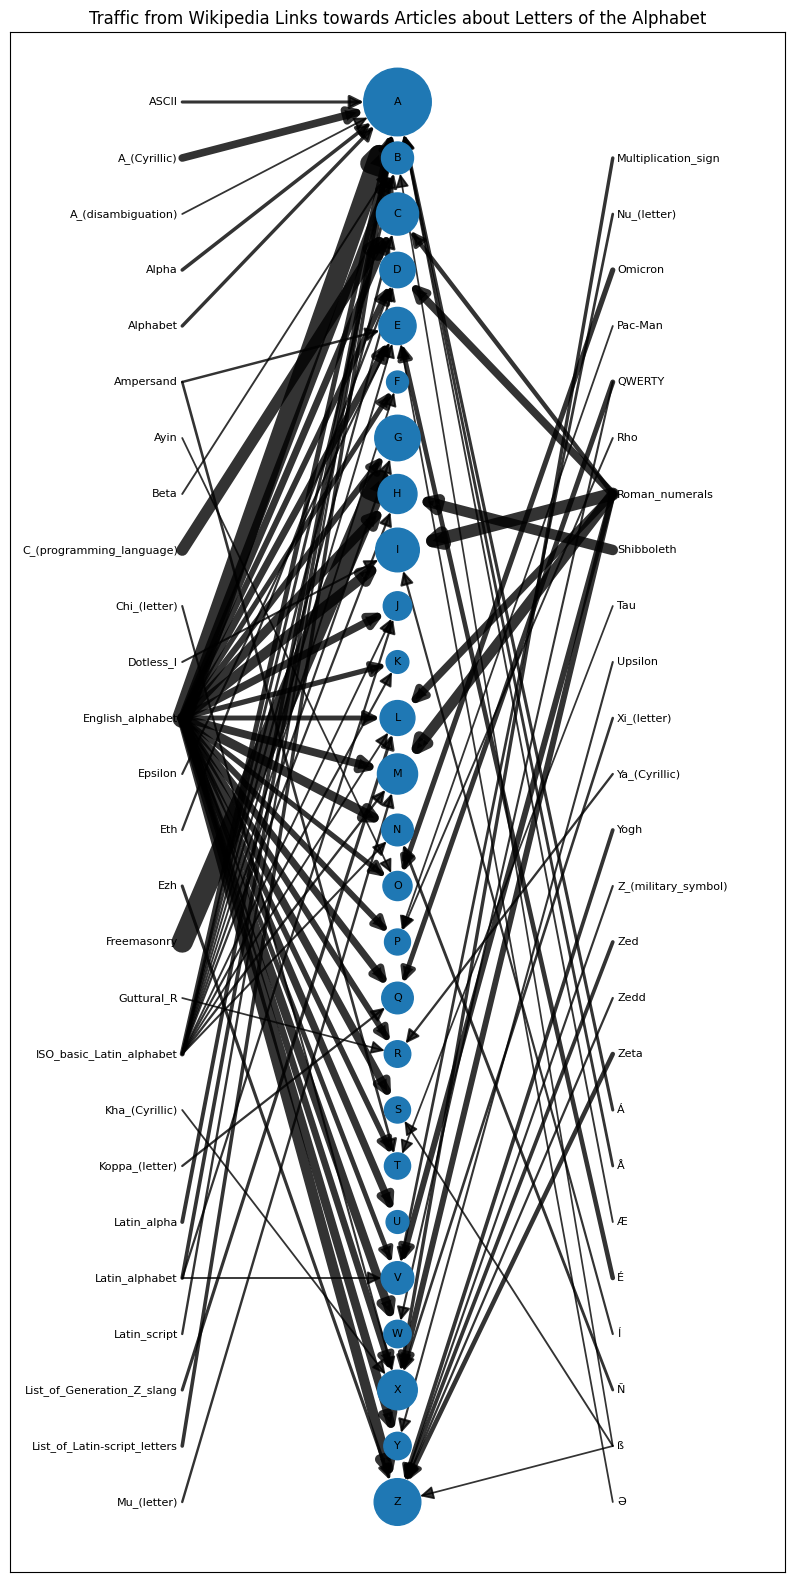

In [12]:
# considering the top 100 links from Wikipedia articles to the letter articles:
elw = dfl.rename(columns={'n':'weight'}).groupby(['source', 'target'])['weight'].sum().sort_values(ascending=False).reset_index().iloc[:100]
az_wikilinks_fig(elw)

#### Comparison with wider patterns

The increase in traffic towards letter articles is not reflected in wider access patterns towards all articles. What other (groups of) articles might be affected? Why? And where is this traffic really coming from?

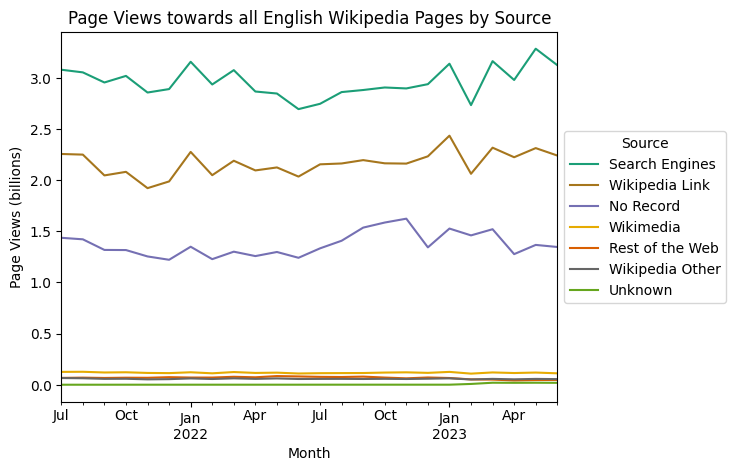

In [13]:
# compare page views from different sources across all of English Wikipedia

gp = dfg/1000000000
gp = gp[gp.sum().sort_values(ascending=False).index] # sort plots & legend
for source in gp.columns: # plot source, consistent colours
    gp[source].plot(color=source_colours[source])

plt.title('Page Views towards all English Wikipedia Pages by Source')
plt.ylabel('Page Views (billions)')
plt.xlabel('Month')
plt.legend(title='Source', bbox_to_anchor=(1, 0.75))
plt.savefig('figures/allwiki_pageview_sources.png', dpi=300, bbox_inches='tight')
plt.show()